We will instantiate the ExcitonDriver class as an array of 5 monomers spaced along the x-axis.
Each monomer will have an exciton energy of 1.5 and a transition dipole moment along z with a magnitude of 0.5.

In [1]:
import wptherml
from matplotlib import pyplot as plt
import numpy as np
import math

from matplotlib import animation, rc
from IPython.display import HTML
#from PIL import Image as 


args = {  
'exciton_energy': 1.5,
'number_of_monomers' : 2,
'displacement_between_monomers' : np.array([1, 0, 0]), 
'transition_dipole_moment' : np.array([0, 0, 0.5]) 
}  

sf = wptherml.SpectrumFactory()  
test = sf.spectrum_factory('Frenkel', args)
test.build_exciton_hamiltonian()


We will call the `compute_exciton_wavefunction_site_basis()`, which 
will evaluate the wavefunctions localized along the sites of each monomer as follows:

$$ \phi_n(x) = a \: {\rm exp}\left( -\frac{(x-x_n)^2}{2c^2} \right) $$

where $x_n$ is x-coordinate for the center of mass of exciton on site $n$.

In [2]:
test.compute_exciton_wavefunction_site_basis()

Calling this method also create a grid of $x$ values spanning values between `.x_min` and `.x_max`, which are derived
from the `.number_of_monomers` and `.displacement_between_monomers` attributes.

In [3]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()
plt.close()

### parameters for plot
ax.set_xlim((test.x_min, test.x_max))
ax.set_ylim((-2, 2))

line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)
plt.show()
#plt.savefig("exciton_plot.png")

We can plot a few of these exciton wavefunctions as follows:

IndexError: index 2 is out of bounds for axis 1 with size 2

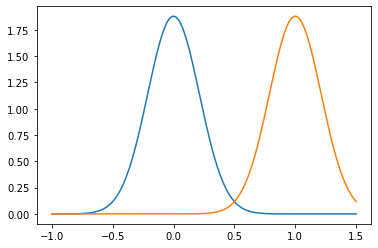

In [4]:
plt.plot(test.x, test.phi[:,0], label="$\phi_1(x)$")
plt.plot(test.x, test.phi[:,1], label="$\phi_2(x)$")
plt.plot(test.x, test.phi[:,2], label="$\phi_3(x)$")
plt.legend()
plt.show()

The following animates the dynamics of a exciton wavefunction given for the chain of monomers that takes 
on the simple form

$$ \Psi(x,t) = \sqrt{\frac{1}{2}} {\rm cos}\left(\frac{\epsilon}{\hbar} t \right) \phi_1(x) + \sqrt{\frac{1}{2}} {\rm sin}\left(\frac{\epsilon}{\hbar} t \right) \phi_2(x) \equiv c_1(t) \phi_1(x) + c_2(t) \phi_2(x) $$
where $\epsilon$ is the bare exciton energy.  

We will want to evaluate the coefficients $c_n(t)$ by integrating the time-dependent Schrodinger equation, but otherwise the animation will follow a similar pattern.

In [ ]:
N_time = 100
t = np.zeros(N_time)


# animation function. This is called sequentially  
def animate(i):
    t = i / 10
    E = test._rk_exciton(0.5) #<== run your rk4 method here!
    rho_11 = np.real( np.conj(test.c_vector[0]) * test.c_vector[0])
    rho_22 = np.real( np.conj(test.c_vector[1]) * test.c_vector[1])
    y = (rho_11 * test.phi[:,0] + rho_22 * test.phi[:,1]) ** 2 
    line.set_data(test.x, y)
    return (line,)
  

anim = animation.FuncAnimation(fig, animate, init_func=init,
                             frames=N_time, interval=200, blit=True)

# Note: below is the part which makes it work on Colab
rc('animation', html='jshtml')
anim
anim.save('exciton_pd.gif', dpi=1000)#, save_all="true", loops=0)